# Initial protype of the Euler inversion code

In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import harmonica as hm
import verde as vd

## Make synthetic data

In [2]:
random = np.random.RandomState(0)

In [3]:
region = [50e3, 150e3, 100e3, 250e3]
height = 1500
#coordinates = vd.scatter_points(region, size=1000, random_state=0, extra_coords=height)
coordinates = [i.ravel() for i in vd.grid_coordinates(region, shape=(40, 40), extra_coords=height)]
x, y, z = coordinates
center = [110e3, 200e3, -5e3]
mass = 200 * 4 / 3 * np.pi * np.abs(center[2]) ** 3
base_level = 3
gravity = hm.point_mass_gravity(coordinates, center, mass, field="g_z") + base_level
delta = 1
xderiv = (
    hm.point_mass_gravity((x + delta, y, z), center, mass, field="g_z")
    - hm.point_mass_gravity((x - delta, y, z), center, mass, field="g_z")
) / 2 * delta
yderiv = (
    hm.point_mass_gravity((x, y + delta, z), center, mass, field="g_z")
    - hm.point_mass_gravity((x, y - delta, z), center, mass, field="g_z")
) / 2 * delta
zderiv = (
    hm.point_mass_gravity((x, y, z + delta), center, mass, field="g_z")
    - hm.point_mass_gravity((x, y, z - delta), center, mass, field="g_z")
) / 2 * delta


gravity += random.normal(loc=0, scale=0.5, size=gravity.size)
xderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)
yderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)
zderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)

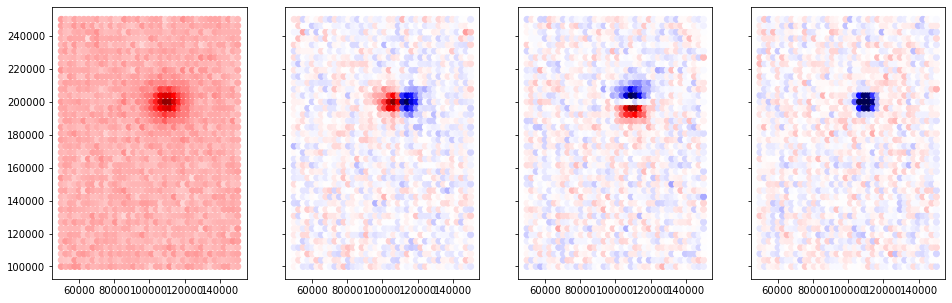

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

scale = 0.002
cmap = "seismic"

ax = axes[0]
ax.scatter(x, y, c=gravity, cmap=cmap, vmin=-20, vmax=20)

for ax, data in zip(axes[1:], [xderiv, yderiv, zderiv]):
    ax.scatter(x, y, c=data, cmap=cmap, vmin=-scale, vmax=scale)

## Calculate the matrices involved

In [5]:
def jacobian_parameters(xderiv, yderiv, zderiv, structural_index):
    """
    Calculate the model parameter Jacobian.
    """
    jacobian = np.empty((xderiv.size, 4))
    jacobian[:, 0] = -xderiv
    jacobian[:, 1] = -yderiv
    jacobian[:, 2] = -zderiv
    jacobian[:, 3] = -structural_index
    return jacobian

In [6]:
def jacobian_data(x, y, z, xo, yo, zo, structural_index):
    """
    Calculate the data Jacobian.
    """
    nequations = x.size
    ndata = nequations * 4
    diagonal = np.arange(nequations)
    jacobian = sparse.hstack(
        [
            sparse.diags(np.full(nequations, structural_index)),
            sparse.diags(x - xo),
            sparse.diags(y - yo),
            sparse.diags(z - zo),
        ],
        format="csc",
    )
    return jacobian

In [7]:
def eulers_equation(x, y, z, data, parameters, structural_index):
    """
    Evaluate Euler's equation.
    """
    nequations = x.size
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, baselevel = parameters
    euler = (
        (x - xo) * dx + (y - yo) * dy + (z - zo) * dz + structural_index * (h - baselevel)
    )
    return euler

In [8]:
def gauss_newton_step(parameters, data, coordinates, data_observed, Wd_inv, Wp, structural_index):
    """
    Take a step in Gauss-Newton and return new parameters and data.
    """
    x, y, z = coordinates
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, base_level = parameters
    A = jacobian_parameters(dx, dy, dz, structural_index)
    B = jacobian_data(x, y, z, xo, yo, zo, structural_index)    
    r = data_observed - data
    f = eulers_equation(x, y, z, data, parameters, structural_index)
    Q = B @ Wd_inv @ B.T
    Q_inv = sparse.linalg.inv(Q)
    ATQ = A.T @ Q_inv
    BTQ = B.T @ Q_inv
    Br = B @ r
    Wd_invBTQ = Wd_inv @ BTQ
    deltap = np.linalg.solve(
        ATQ @ A + Wp,
        -ATQ @ (f + Br)
    )
    deltad = r - Wd_invBTQ @ Br - Wd_invBTQ @ (f + A @ deltap)
    return deltap, deltad

In [9]:
def euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index, step=156, step_change=2, maxit=100, tol=1e-5):
    """
    """
    region = vd.get_region(coordinates)
    area = (region[1] - region[0]) * (region[3] - region[2]) / 2
    data_observed = np.concatenate([field, xderiv, yderiv, zderiv])
    
    parameters = np.array([
        0.5 * (region[1] + region[0]),
        0.5 * (region[3] + region[2]),
        -np.mean(coordinates[2]),
        0,
    ])
    data = np.zeros_like(data_observed)
    data = 0.1 * np.copy(data_observed)
    
    derivative_norm = np.mean([
        np.linalg.norm(xderiv),
        np.linalg.norm(yderiv),
        np.linalg.norm(zderiv),        
    ])    
    #wd = np.concatenate([
    #    np.full_like(field, 1 / np.linalg.norm(field) ** 2),
    #    np.full_like(field, 1 / np.linalg.norm(xderiv) ** 2),
    #    np.full_like(field, 1 / np.linalg.norm(yderiv) ** 2),
    #    np.full_like(field, 1 / np.linalg.norm(zderiv) ** 2),
    #])
    wd = np.concatenate([
        np.full_like(field, 1 / np.linalg.norm(field) ** 2),
        np.full_like(field, 1 / derivative_norm ** 2),
        np.full_like(field, 1 / derivative_norm ** 2),
        np.full_like(field, 1 / derivative_norm ** 2),
    ])
    #wd = np.ones_like(data)
    
    wp = np.array([
        1 / area,
        1 / area,
        1 / area,
        1 / np.linalg.norm(field) ** 2,
    ])
    wp = np.where(wp > 1e-15, wp, 1e-15)
    
    print("Data weights:", wd)
    print("Parameter weights:", wp)
    
    Wd_inv = sparse.diags(1 / wd, format="csc")
    Wp = sparse.diags(wp, format="csc")
    
    euler_misfit = np.linalg.norm(eulers_equation(*coordinates, data, parameters, structural_index))
    misfit = np.linalg.norm(data_observed - data)
    print("Initial state | Euler misfit: {:.3f} | data misfit: {:.3f} | step: {}".format(euler_misfit, misfit, step))
    
    maxit_step = 10
    
    for i in range(maxit):
        for j in range(maxit_step):
            deltap, deltad = gauss_newton_step(
                parameters,
                data, 
                coordinates, 
                data_observed, 
                (1 / step) * Wd_inv, 
                step * Wp, 
                structural_index,
            )
            new_misfit = np.linalg.norm(data_observed - data - deltad)
            if (new_misfit >= misfit):         
                if step > 1e-10:
                    step = step / step_change        
            else:
                if step < 1e10:
                    step = step * step_change   
                break
        else:
            # Only executed if exited the for loop without reaching a break
            # indicating that the new misfit is never smaller. In that case
            # break out of the iterations due to stagnation.
            print("Exited because of stagnation (step : {})".format(step))
            break            
        # This runs if a step decreases the misfit
        parameters += deltap
        data += deltad
        misfit_change = np.abs(misfit - new_misfit) / misfit
        misfit = new_misfit
        euler_misfit = np.linalg.norm(
            eulers_equation(*coordinates, data, parameters, structural_index)
        )
        print(" delta p: {} | Euler misfit: {:.3f} | data misfit: {:.3f} | step: {:.5e}".format(deltap, euler_misfit, misfit, step))
        if misfit_change < tol:
            break
    field_pred, dx_pred, dy_pred, dz_pred = np.split(data, 4)
    return parameters, field_pred, dx_pred, dy_pred, dz_pred

In [10]:
%%time
p, h, dx, dy, dz = euler_inversion(
    coordinates, gravity, xderiv, yderiv, zderiv, 
    structural_index=2, 
    step=1,
    maxit=100,
    tol=1e-3,
)

Data weights: [5.27705351e-05 5.27705351e-05 5.27705351e-05 ... 1.72294591e+04
 1.72294591e+04 1.72294591e+04]
Parameter weights: [1.33333333e-10 1.33333333e-10 1.33333333e-10 5.27705351e-05]
Initial state | Euler misfit: 36.002 | data misfit: 123.893 | step: 1
 delta p: [ 2.20088575e+03  4.81171382e+03 -1.49308205e+03  3.06841027e+00] | Euler misfit: 24.505 | data misfit: 59.832 | step: 2.00000e+00
 delta p: [ 4.81292989e+03  1.18519719e+04 -2.02636799e+03 -5.46337042e-02] | Euler misfit: 15.371 | data misfit: 44.551 | step: 4.00000e+00
 delta p: [ 1.66295287e+03  4.81985212e+03  2.04479703e+02 -2.07762530e-02] | Euler misfit: 4.461 | data misfit: 35.538 | step: 8.00000e+00
 delta p: [ 6.54867241e+02  1.90612990e+03  1.53126467e+01 -3.41052506e-05] | Euler misfit: 0.479 | data misfit: 33.111 | step: 1.60000e+01
 delta p: [2.31206390e+02 7.32261226e+02 2.64426246e+01 1.38085612e-03] | Euler misfit: 0.062 | data misfit: 32.643 | step: 3.20000e+01
 delta p: [8.45559839e+01 2.82667318e+02

In [11]:
print(" ".join("{:.1f}".format(i) for i in p))
print(" ".join("{:.1f}".format(i) for i in center), "{:.1f}".format(base_level))

109688.5 199555.1 -4762.9 3.0
110000.0 200000.0 -5000.0 3.0


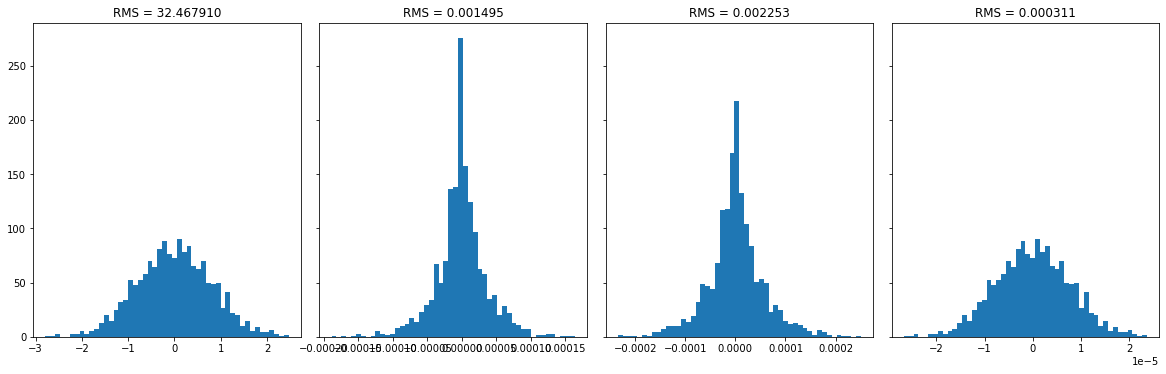

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

for ax, obs, pred in zip(axes, [gravity, xderiv, yderiv, zderiv], [h, dx, dy, dz]):
    r = obs - pred
    ax.hist(r, bins=50)
    ax.set_title("RMS = {:.6f}".format(np.linalg.norm(r)))
plt.tight_layout(pad=0)

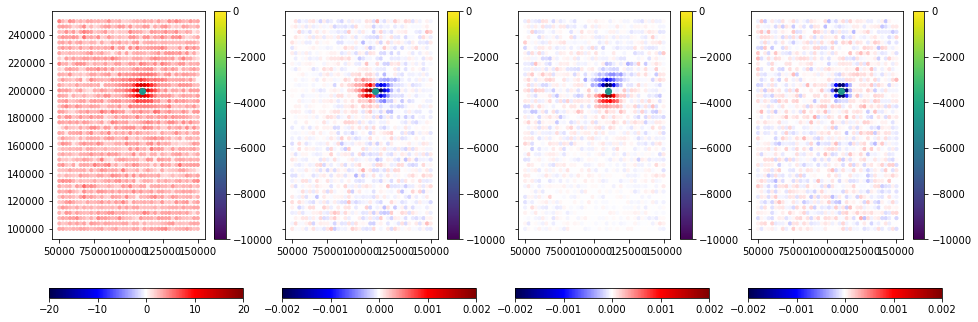

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6), sharey=True)

scale = 0.002
cmap = "seismic"
size = 10

ax = axes[0]
tmp = ax.scatter(x, y, c=h, s=size, cmap=cmap, vmin=-20, vmax=20) 
plt.colorbar(tmp, ax=ax, orientation="horizontal")

for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.scatter(x, y, c=data, s=size, cmap=cmap, vmin=-scale, vmax=scale)
    plt.colorbar(tmp, ax=ax, orientation="horizontal")
    
for ax in axes:
    tmp = ax.scatter(p[0], p[1], c=p[2], vmin=-10e3, vmax=0)
    plt.colorbar(tmp, ax=ax)  
    ax.set_aspect("equal")

In [14]:
%%time
p, h, dx, dy, dz = euler_inversion(
    coordinates, gravity, xderiv, yderiv, zderiv, 
    structural_index=3, 
    step=1,
    maxit=100,
    tol=1e-3,
)

Data weights: [5.27705351e-05 5.27705351e-05 5.27705351e-05 ... 1.72294591e+04
 1.72294591e+04 1.72294591e+04]
Parameter weights: [1.33333333e-10 1.33333333e-10 1.33333333e-10 5.27705351e-05]
Initial state | Euler misfit: 46.319 | data misfit: 123.893 | step: 1
 delta p: [ 1247.6759241   2713.14480134 -1722.83403149     3.12225103] | Euler misfit: 19.753 | data misfit: 57.273 | step: 2.00000e+00
 delta p: [ 4.08616675e+03  9.76689677e+03 -4.04866400e+03 -1.19707961e-02] | Euler misfit: 7.029 | data misfit: 45.112 | step: 4.00000e+00
 delta p: [ 1.96972141e+03  5.35023423e+03 -8.45067243e+02  7.22961183e-04] | Euler misfit: 3.088 | data misfit: 39.631 | step: 8.00000e+00
 delta p: [ 1.03713395e+03  2.95466643e+03 -3.27564152e+02  1.51892958e-03] | Euler misfit: 0.697 | data misfit: 37.173 | step: 1.60000e+01
 delta p: [ 4.98951093e+02  1.52789437e+03 -8.89906379e+01  1.68489629e-03] | Euler misfit: 0.170 | data misfit: 36.310 | step: 3.20000e+01
 delta p: [ 2.38851783e+02  7.82870922e+0

In [15]:
print(" ".join("{:.1f}".format(i) for i in p))
print(" ".join("{:.1f}".format(i) for i in center), "{:.1f}".format(base_level))

109269.5 198799.8 -8571.1 3.1
110000.0 200000.0 -5000.0 3.0


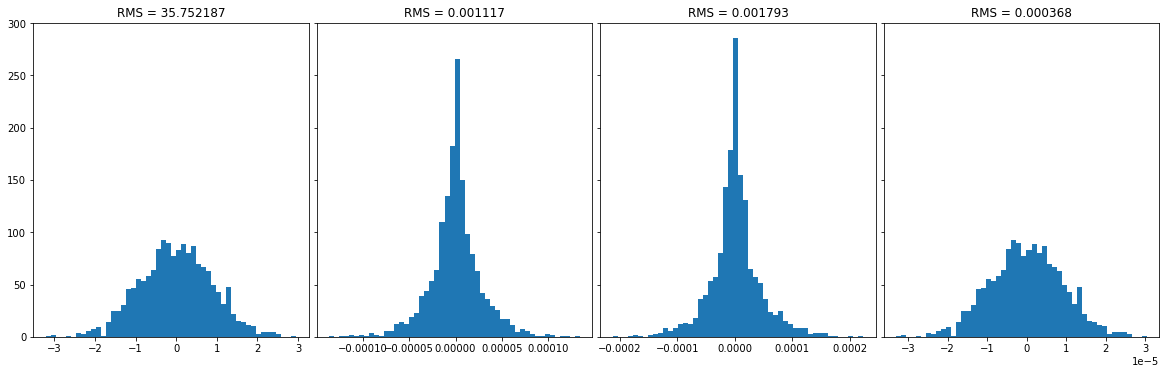

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

for ax, obs, pred in zip(axes, [gravity, xderiv, yderiv, zderiv], [h, dx, dy, dz]):
    r = obs - pred
    ax.hist(r, bins=50)
    ax.set_title("RMS = {:.6f}".format(np.linalg.norm(r)))
plt.tight_layout(pad=0)

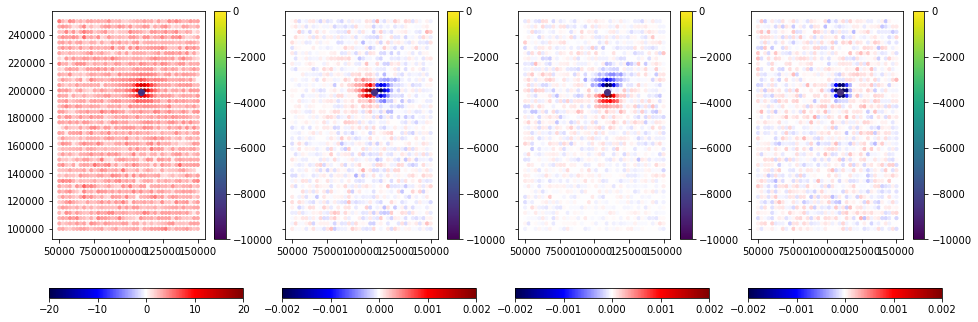

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6), sharey=True)

scale = 0.002
cmap = "seismic"
size = 10

ax = axes[0]
tmp = ax.scatter(x, y, c=h, s=size, cmap=cmap, vmin=-20, vmax=20) 
plt.colorbar(tmp, ax=ax, orientation="horizontal")

for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.scatter(x, y, c=data, s=size, cmap=cmap, vmin=-scale, vmax=scale)
    plt.colorbar(tmp, ax=ax, orientation="horizontal")
    
for ax in axes:
    tmp = ax.scatter(p[0], p[1], c=p[2], vmin=-10e3, vmax=0)
    plt.colorbar(tmp, ax=ax)  
    ax.set_aspect("equal")

In [18]:
%%time
p, h, dx, dy, dz = euler_inversion(
    coordinates, gravity, xderiv, yderiv, zderiv, 
    structural_index=1, 
    step=1,
    maxit=100,
    tol=1e-3,
)

Data weights: [5.27705351e-05 5.27705351e-05 5.27705351e-05 ... 1.72294591e+04
 1.72294591e+04 1.72294591e+04]
Parameter weights: [1.33333333e-10 1.33333333e-10 1.33333333e-10 5.27705351e-05]
Initial state | Euler misfit: 28.739 | data misfit: 123.893 | step: 1
 delta p: [ 4.10689755e+03  9.02760113e+03 -1.48691938e+02  2.93695685e+00] | Euler misfit: 28.748 | data misfit: 52.255 | step: 2.00000e+00
 delta p: [ 4.75386314e+03  1.20099948e+04 -1.76582655e+01 -3.76852168e-01] | Euler misfit: 26.958 | data misfit: 45.426 | step: 4.00000e+00
 delta p: [ 7.26630402e+02  2.63296972e+03  7.36868772e+02 -2.92396804e-01] | Euler misfit: 4.844 | data misfit: 30.528 | step: 8.00000e+00
 delta p: [2.38150222e+02 7.68881468e+02 2.69135441e+01 4.77158481e-03] | Euler misfit: 0.218 | data misfit: 28.615 | step: 1.60000e+01
 delta p: [6.92510213e+01 2.70608460e+02 3.00169014e+01 2.95289952e-03] | Euler misfit: 0.019 | data misfit: 28.458 | step: 3.20000e+01
 delta p: [ 2.08970288e+01  8.30804816e+01  

In [19]:
print(" ".join("{:.1f}".format(i) for i in p))
print(" ".join("{:.1f}".format(i) for i in center), "{:.1f}".format(base_level))

109915.7 199793.1 -870.4 2.3
110000.0 200000.0 -5000.0 3.0


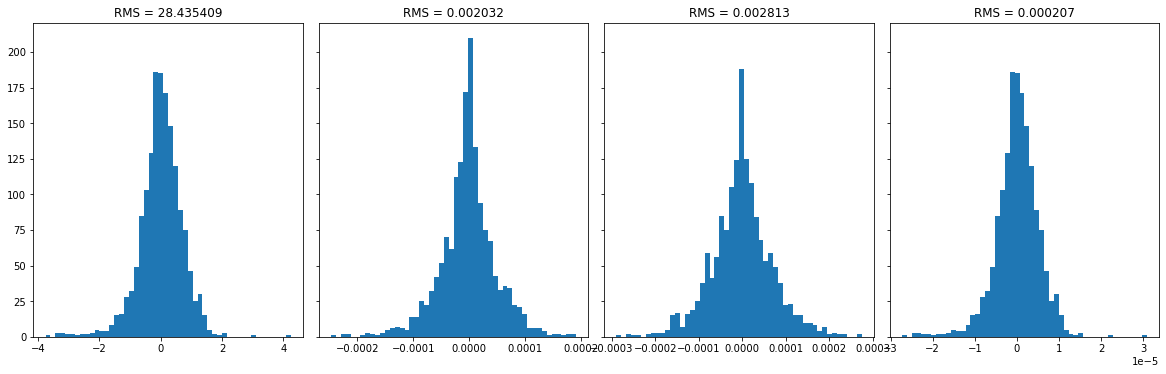

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

for ax, obs, pred in zip(axes, [gravity, xderiv, yderiv, zderiv], [h, dx, dy, dz]):
    r = obs - pred
    ax.hist(r, bins=50)
    ax.set_title("RMS = {:.6f}".format(np.linalg.norm(r)))
plt.tight_layout(pad=0)

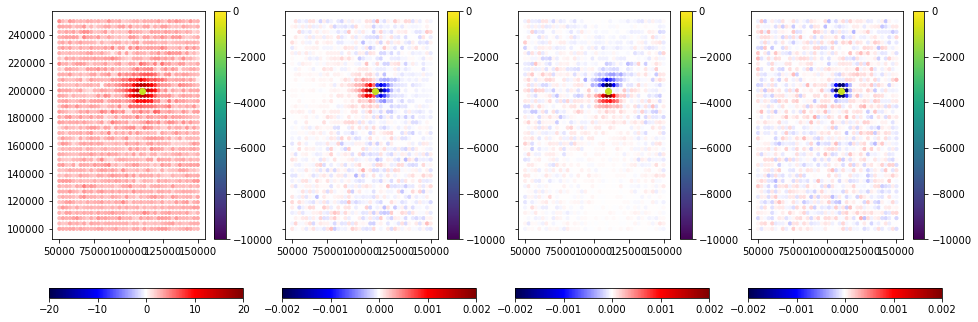

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6), sharey=True)

scale = 0.002
cmap = "seismic"
size = 10

ax = axes[0]
tmp = ax.scatter(x, y, c=h, s=size, cmap=cmap, vmin=-20, vmax=20) 
plt.colorbar(tmp, ax=ax, orientation="horizontal")

for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.scatter(x, y, c=data, s=size, cmap=cmap, vmin=-scale, vmax=scale)
    plt.colorbar(tmp, ax=ax, orientation="horizontal")
    
for ax in axes:
    tmp = ax.scatter(p[0], p[1], c=p[2], vmin=-10e3, vmax=0)
    plt.colorbar(tmp, ax=ax)  
    ax.set_aspect("equal")